In [4]:
import keras

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
!pip install h5py

In [0]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
filename = '/content/gdrive/My Drive/SVHN_single_grey1.h5'
f = h5py.File(filename,'r')

In [8]:
# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())
print(a_group_key)

Keys: KeysView(<HDF5 file "SVHN_single_grey1.h5" (mode r)>)
['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


In [0]:
x_train = np.array(f['X_train'])
y_train = np.array(f['y_train'])
x_val = np.array(f['X_val'])
y_val = np.array(f['y_val'])
x_test = np.array(f['X_test'])
y_test = np.array(f['y_test'])

In [10]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(42000, 32, 32)
(60000, 32, 32)
(18000, 32, 32)


In [0]:
import cv2

In [0]:
def resize(data):
  return cv2.resize(data, dsize=(16,16), interpolation = cv2.INTER_LANCZOS4)

In [0]:
import numpy as np
x_train_resize = np.zeros(shape =(42000,16,16))
x_test_resize = np.zeros(shape = (18000,16,16))

for i in range(0,len(x_train)):
  x_train_resize[i] = resize(x_train[i])
for i in range(0,len(x_test)):
  x_test_resize[i] = resize(x_test[i])

In [0]:
#x_train_reshape = x_train_resize.reshape(x_train_resize.shape[0],1024)
x_train_reshape = x_train.reshape(x_train.shape[0],1024)
#x_test_reshape = x_test_resize.reshape(x_test_resize.shape[0],1024)
x_test_reshape = x_test.reshape(x_test.shape[0],1024)

In [0]:
scaler = StandardScaler()
eda_scaled = scaler.fit_transform(x_train_reshape)
eda_scaled_t = scaler.fit_transform(x_test_reshape)

In [0]:
def data_manipul(data):
  cov_matrix = np.cov(eda_scaled.T)
  e_vals, e_vecs = np.linalg.eig(cov_matrix)
  tot = sum(e_vals)
  var_exp = [( i /tot ) * 100 for i in sorted(e_vals, reverse=True)]
  cum_var_exp = np.cumsum(var_exp)
  print("Cumulative Variance Explained", cum_var_exp)
  # Ploting 
  plt.figure(figsize=(10 , 5))
  plt.bar(range(1, e_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
  plt.step(range(1, e_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
  plt.ylabel('Explained Variance Ratio')
  plt.xlabel('Principal Components')
  plt.legend(loc = 'best')
  plt.tight_layout()
  plt.show()

Cumulative Variance Explained [ 55.98192154  62.46838823  67.74844409 ...  99.99999041  99.99999535
 100.        ]


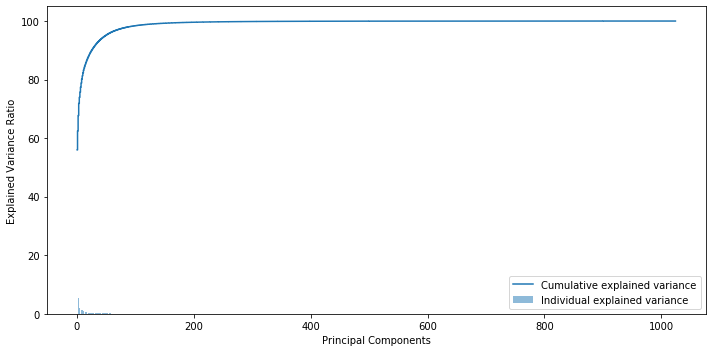

In [19]:
data_manipul(eda_scaled)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=45)
principalComponents = pca.fit_transform(eda_scaled)

In [0]:
principalComponents_t = pca.transform(eda_scaled_t)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [23]:
accuracies = []
for i in range(30,100,10):
  model = KNeighborsClassifier(n_neighbors=i, weights ='distance', p=1)
  model.fit(principalComponents, y_train)
  # evaluate the model and update the accuracies list
  score = model.score(principalComponents_t, y_test)
  print("k=%d, accuracy=%.2f%%" % (i, score * 100))
  accuracies.append(score)

k=30, accuracy=61.59%
k=40, accuracy=61.62%
k=50, accuracy=61.63%
k=60, accuracy=61.62%
k=70, accuracy=61.91%
k=80, accuracy=61.82%
k=90, accuracy=61.74%




From above, we can see an accuracy of 61.91% for k=70 and on using distance based weighted KNN and Manhattan Distance as the metric.

In [0]:
model_opti = KNeighborsClassifier(n_neighbors=70, weights = 'distance', p=1, algorithm = 'ball_tree' )
model_opti.fit(principalComponents, y_train)
# evaluate the model and update the accuracies list
y_pred = model_opti.predict(principalComponents_t)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
score = model_opti.score(principalComponents_t, y_test)
print('Overall Accuracy Score', score)

              precision    recall  f1-score   support

           0       0.55      0.75      0.63      1814
           1       0.53      0.78      0.63      1828
           2       0.77      0.60      0.67      1803
           3       0.59      0.50      0.54      1719
           4       0.71      0.73      0.72      1812
           5       0.61      0.51      0.56      1768
           6       0.62      0.52      0.56      1832
           7       0.75      0.69      0.72      1808
           8       0.56      0.52      0.54      1812
           9       0.61      0.58      0.59      1804

    accuracy                           0.62     18000
   macro avg       0.63      0.62      0.62     18000
weighted avg       0.63      0.62      0.62     18000

Overall Accuracy Score 0.6191111111111111


In [0]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, Reshape, BatchNormalization
from keras import backend as K
#K.set_image_dim_ordering('th')

In [0]:
x_train = x_train.reshape(x_train.shape[0], 1,32,32).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 1,32,32).astype('float32')
x_train /= 255
x_test /= 255

In [0]:
y_train_dum = keras.utils.to_categorical(y_train,num_classes=10)
y_test_dum = keras.utils.to_categorical(y_test,num_classes=10)

In [0]:
# Define Model
    model_cnn = Sequential()
    
    # 1st Conv Layer
    model_cnn.add(Convolution2D(32,(3, 3), input_shape=(1,32,32), data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Activation('relu'))
    # Max Pooling
    #model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    # Dropout
    model_cnn.add(Dropout(0.2))


    # 2nd Conv Layer
    model_cnn.add(Convolution2D(64,(3, 3), data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Activation('relu'))
    # Max Pooling
    model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    # Dropout
    model_cnn.add(Dropout(0.2))

    
     # 3rd Conv Layer
    model_cnn.add(Convolution2D(64,(3, 3), data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Activation('relu'))
    # Max Pooling
    model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    # Dropout
    model_cnn.add(Dropout(0.2))
    
     
     # 4th Conv Layer
    model_cnn.add(Convolution2D(64,(3, 3), data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Activation('relu'))
    # Max Pooling
    #model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    # Dropout
    model_cnn.add(Dropout(0.25))
    
    # Fully Connected Layer
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dense(256, activation='relu'))
        
    # Prediction Layer
    model_cnn.add(Dense(10, activation = 'softmax'))
    
    # Loss and Optimizer
    model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Store Training Results
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, verbose=1, mode='auto')
    callback_list = [early_stopping]

    # Train the model
    model_cnn.fit(x_train, y_train_dum, batch_size=32, nb_epoch=20, 
              validation_data=(x_test, y_test_dum), callbacks = callback_list)

In [0]:
y_pred = model_cnn.predict_classes(x_test)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))